In [122]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix


In [123]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=1999):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)


X, y = generar_datos()

Decir y~a+b en realidad es una formula de la pinta: y_i = B0 + (B1 * a_i) + (B2 * b_i) + epsilon ---> variable aleatoria, tiene que ver con el error? 

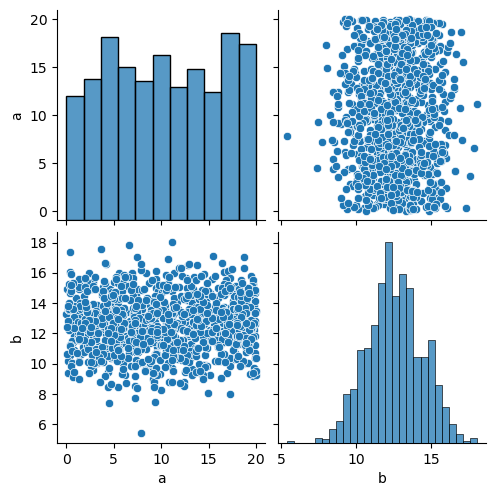

In [124]:
sns.pairplot(X)

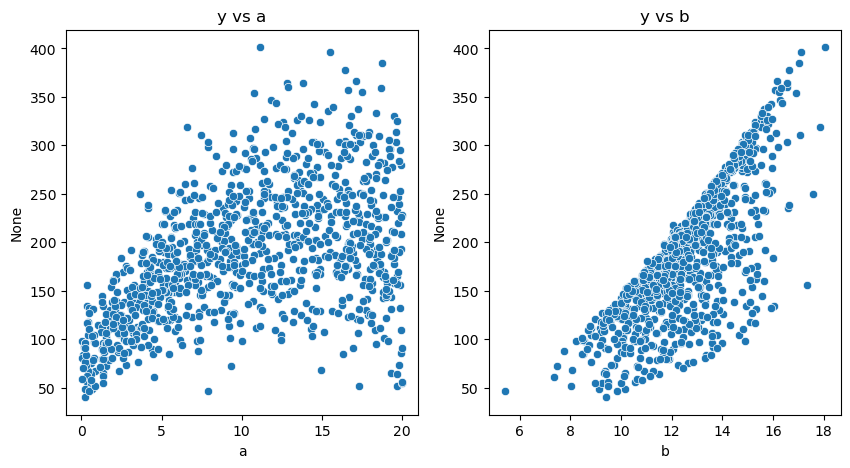

In [125]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
for i, col in enumerate(X):
    sns.scatterplot(x=X[col], y=y, ax=axs[i])
    axs[i].set_title(f"y vs {col}")

In [126]:
test_split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [127]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

LinearRegression()

In [128]:
lr1.intercept_
beta1 = pd.Series(lr1.coef_, index=X_train.columns)
beta1["intercept"] = lr1.intercept_
beta1

a              5.724699
b             27.900786
intercept   -222.930624
dtype: float64

In [129]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [130]:
y_pred = lr1.predict(X_test)
print(
    "# RMSE",
    f"Train: {rmse(lr1.predict(X_train), y_train):.4f}",
    "Test:  %.4f" % rmse(y_pred, y_test),
    sep="\n",
)

# RMSE
Train: 28.3387
Test:  29.6549


In [131]:
df_test = pd.concat(
    [
        X_test,
        y_test.rename("y"),
        pd.Series(y_pred, name="y_pred", index=y_test.index),
    ],
    axis=1,
)
df_test

,a,b,y,y_pred
354,19.356909,14.514779,277.442307,292.855606
475,7.486540,10.814008,151.103868,121.646900
610,5.293828,11.500627,148.383035,128.251480
101,15.567373,12.857293,227.501175,224.916468
688,1.438236,11.949321,86.814050,118.698295
...,...,...,...,...
973,12.809961,14.512296,291.986960,255.307003
547,3.994188,12.648079,145.536995,152.826256
24,2.461369,16.018862,184.221945,238.098825
497,3.082782,15.703785,191.985901,232.865317


In [132]:
df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"]
df_test.head()

,a,b,y,y_pred,resid
354,19.356909,14.514779,277.442307,292.855606,-15.413298
475,7.486540,10.814008,151.103868,121.646900,29.456969
610,5.293828,11.500627,148.383035,128.251480,20.131555
101,15.567373,12.857293,227.501175,224.916468,2.584706
688,1.438236,11.949321,86.814050,118.698295,-31.884245


### Análisis de residuos

Chequear metodos enumerate y zip de python, temas axs tambien

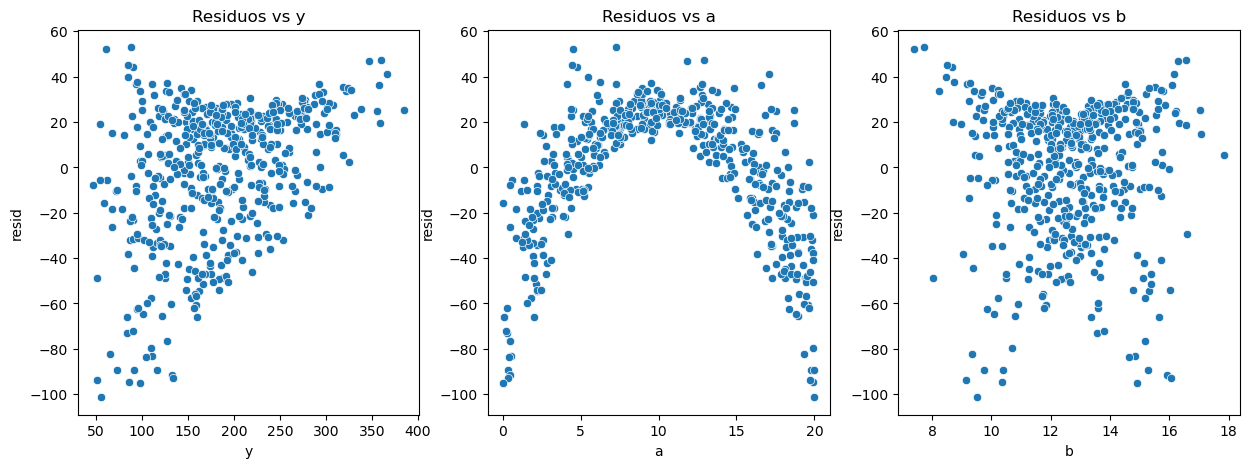

In [133]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

Pareciera haber alguna relación cuadrática entre los residuos y $a$, entonces...

In [134]:
formula = " ~ poly(a, 2, raw=True) * b"
# Como solo tiene RHS, no devuelve $y$
X_train2 = model_matrix(formula, data=X_train)
X_train2.head()
# pueden explicar por qué quedan las columnas que quedas?

,Intercept,"poly(a, 2, raw=True)[0]","poly(a, 2, raw=True)[1]",b,"poly(a, 2, raw=True)[0]:b","poly(a, 2, raw=True)[1]:b"
883,1.0,9.167831,84.049119,9.408962,86.259769,790.814958
619,1.0,4.437696,19.693148,12.146326,53.901703,239.199382
710,1.0,18.604093,346.112279,11.921235,221.783770,4126.085905
908,1.0,19.191664,368.319976,11.379220,218.386170,4191.194047
441,1.0,14.001344,196.037622,9.991219,139.890496,1958.654898


In [135]:
import re


def nombres_poli(s):
    repl = lambda m: f"{m.group(1)}^{int(m.group(2))+1}"
    nombres = re.sub(r"poly\((\w), \d+, raw=True\)\[(\d)\]", repl, s).replace("^1", "")
    return nombres

np.vectorize(nombres_poli)(X_train2.columns)

array(['Intercept', 'a', 'a^2', 'b', 'a:b', 'a^2:b'], dtype='<U9')

### np.vectorize

In [136]:
assert all(
    np.vectorize(nombres_poli)(X_train2.columns)
    == [nombres_poli(c) for c in X_train2.columns]
)

In [137]:
lr2 = LinearRegression(fit_intercept=False)  # Ya está incluido en model_matrix
lr2.fit(X_train2, y_train)

LinearRegression(fit_intercept=False)

In [138]:
def betas(lr, train):
    beta = pd.Series(lr.coef_, index=train.columns)
    if lr.fit_intercept:
        beta["Intercept"] = lr.intercept_
    beta.index = beta.index.map(nombres_poli)
    return beta


betas(lr2, X_train2)

Intercept   -89.389516
a             2.906843
a^2          -0.800704
b            12.825732
a:b           1.516468
a^2:b        -0.000192
dtype: float64

In [139]:
def mostrar_rmse(lr, X_train, y_train, X_test, y_test):
    print(
        "# RMSE",
        f"Train: {rmse(lr.predict(X_train), y_train):.4f}",
        "Test:  %.4f" % rmse(lr.predict(X_test), y_test),
        sep="\n",
    )


mostrar_rmse(lr2, X_train2, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 4.8447
Test:  4.9246


In [140]:
y_pred2 = lr2.predict(model_matrix(formula, data=X_test))
df_test = df_test.rename(columns={"y_pred": "y_pred1", "resid": "resid1"})
df_test["y_pred2"] = y_pred2
df_test["resid2"] = df_test["y"] - df_test["y_pred2"]

Text(0.5, 1.0, "92.40% de las observaciones 'ajustan mejor' con lr2")

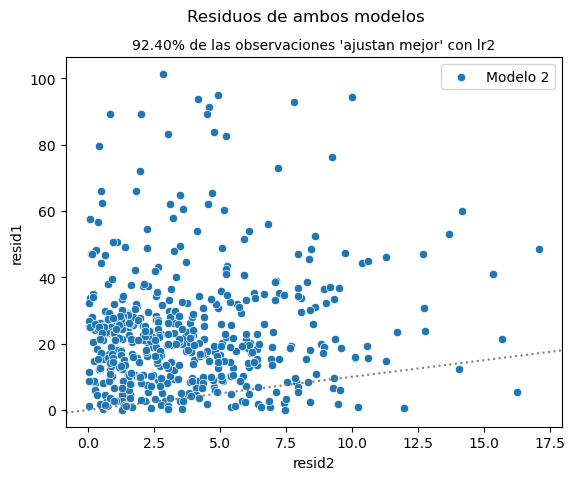

In [141]:
sns.scatterplot(x="resid2", y="resid1", data=df_test.abs(), label="Modelo 2")
plt.axline((0, 0), slope=1, color="gray", linestyle="dotted")
plt.suptitle(f"Residuos de ambos modelos")
perc_mejora = 100 * (df_test.resid2.abs() < df_test.resid1.abs()).mean()
plt.title(f"{perc_mejora:.2f}% de las observaciones 'ajustan mejor' con lr2", fontsize=10)

In [142]:
# Otra manera de calcular RMSE Test
df_test[["resid1", "resid2"]].pow(2).mean().apply(np.sqrt)

resid1    29.654897
resid2     4.924620
dtype: float64

Revisamos otra vez la estructura de los residuos

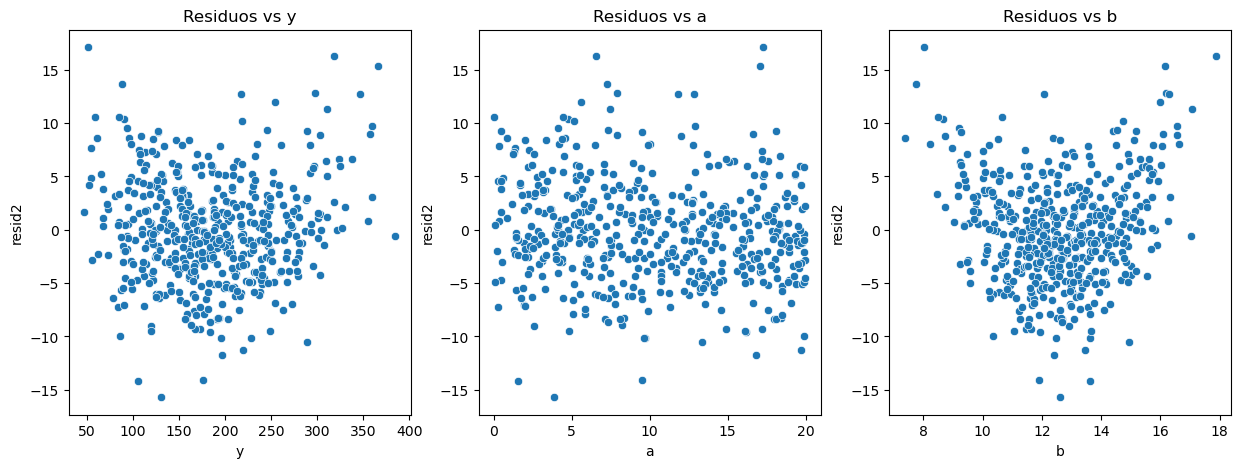

In [143]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid2", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

$y \sim a$ parece bien capturado, pero aún queda una estructura contra $b$. Será cuadrática también?

In [144]:
formula = "~ 0 + poly(a, 2, raw=True) * poly(b, 2, raw=True)"
X_train3 = model_matrix(formula, data=X_train)
X_train3.shape, np.vectorize(nombres_poli)(X_train3.columns)

((500, 8),
 array(['a', 'a^2', 'b', 'b^2', 'a:b', 'a^2:b', 'a:b^2', 'a^2:b^2'],
       dtype='<U7'))

¿Por qué hay 8 terminos y no $3 \times 3=9$? ¿Se acabará algún día este proceso?

## Regresión Grieta (AKA Ridge)

Una hipótesis: si le doy suficientes grados de libertad al modelo, y regularizo fuertemente, debería encontrar un modelo simple que ajuste a los datos sin demasiado esfuerzo. Será verdad?

In [145]:
from sklearn.linear_model import Ridge
formula = "~ 0 + poly(a, 3, raw=True) * poly(b, 3, raw=True)"
X_train4 = model_matrix(formula, data=X_train)

lr4 = Ridge(alpha=100)
lr4.fit(X_train4, y_train)

Ridge(alpha=100)

In [146]:
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 3.8252
Test:  4.2776


In [147]:
pd.DataFrame({"lr2": betas(lr2, X_train2), "lr4": betas(lr4, X_train4)}).round(4)

,lr2,lr4
Intercept,-89.3895,10.9797
a,2.9068,0.0195
a:b,1.5165,0.2695
a:b^2,NaN,0.2256
a:b^3,NaN,-0.0086
a^2,-0.8007,-0.2755
a^2:b,-0.0002,0.0838
a^2:b^2,NaN,-0.0210
a^2:b^3,NaN,0.0009
a^3,NaN,-0.0408


Nada mal! Pero se podrá mejorar aún más? Cómo encunetro el valor óptimo de la penalización $\alpha$? CV al rescate

## Validación cruzada con scikit-learn
### np.logspace

In [148]:
np.logspace(0, 2, 5)

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [149]:
alfas = np.logspace(-3, 3, 61)

In [150]:
alfas[:5].round(3), alfas[-5:].round(3)

(array([0.001, 0.001, 0.002, 0.002, 0.003]),
 array([ 398.107,  501.187,  630.957,  794.328, 1000.   ]))

In [151]:
def norma(vec):
    return np.sqrt((vec ** 2).sum())

In [152]:
assert norma(np.array([3, 4])) == 5

In [153]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


rmse_train = {}
rmse_test = {}
beta_norm = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] = rmse(ridge.predict(X_train4), y_train)
    rmse_test[alfa] = rmse(ridge.predict(model_matrix(formula, X_test)), y_test)
    beta_norm[alfa] = norma(ridge.coef_)
    intercept[alfa] = ridge.intercept_

    logger.info(f"Alfa: {alfa.round(3):.3f}")

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.1847e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.28715e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.41614e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.002
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.57856e-19): result may not be accurate.
  return linalg.solve(A, X

Fíjense qué interesante: efecivamente para alfas muy pequeños, cuando Ridge es casi igual a la reg. lineal "vainilla", la matrix efectivamente está mal condicionada.

In [154]:
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "beta_norm": beta_norm,
        "intercept": intercept,
    }
).reset_index(names="alfa")

In [155]:
data

,alfa,rmse_train,rmse_test,beta_norm,intercept
0,0.001000,3.802046,4.279095,41.386286,-17.128537
1,0.001259,3.802083,4.279356,39.861086,-13.660863
2,0.001585,3.802133,4.279653,38.136678,-9.735393
3,0.001995,3.802200,4.279983,36.227467,-5.384161
4,0.002512,3.802286,4.280339,34.162831,-0.675091
...,...,...,...,...,...
56,398.107171,3.831152,4.284584,0.318722,12.992034
57,501.187234,3.831817,4.285799,0.309610,13.345669
58,630.957344,3.832449,4.287064,0.302562,13.724902
59,794.328235,3.833077,4.288390,0.296873,14.134200


### Interludio: $\alpha \rightarrow \infty$? 

In [156]:
ridge = Ridge(alpha=1e100)
ridge.fit(X_train4, y_train)
ridge.intercept_

187.52298510945843

### np.isclose

In [157]:
assert np.isclose(y_train.mean(), ridge.intercept_)

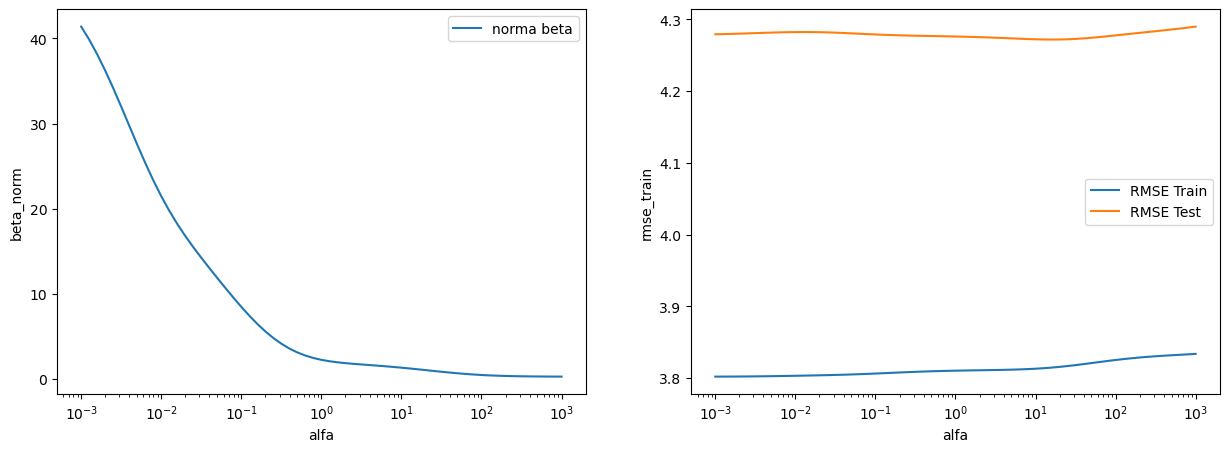

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.lineplot(data=data, x="alfa", y="beta_norm", label="norma beta", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept")
sns.lineplot(data=data, x="alfa", y="rmse_train", label="RMSE Train", ax=axs[1])
sns.lineplot(data=data, x="alfa", y="rmse_test", label="RMSE Test", ax=axs[1])
plt.xscale("log")  # Probar comentando esta línea
plt.legend()

In [159]:
optimo = data.iloc[data.rmse_test.idxmin()]
optimo

alfa          15.848932
rmse_train     3.814618
rmse_test      4.271764
beta_norm      1.156254
intercept      6.817348
Name: 42, dtype: float64

In [160]:
lr4 = Ridge(alpha=optimo.alfa)
lr4.fit(X_train4, y_train)
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 3.8146
Test:  4.2718


In [161]:
betas(lr4, X_train4).abs().sort_values(ascending=False)

Intercept    6.817348
a:b          0.833387
a^2          0.733072
b^2          0.227568
a:b^2        0.138224
a^2:b        0.128780
a            0.128260
a^2:b^2      0.019791
b            0.019363
b^3          0.013623
a^3          0.009044
a:b^3        0.005323
a^3:b        0.001994
a^2:b^3      0.000724
a^3:b^2      0.000449
a^3:b^3      0.000018
dtype: float64

Para reflexionar: ¿Qué es más importante, $$0.000012\ a^3:b^3$$ o $$0.485267\ a:b$$? ¿De qué depende?

### Una vez más, con ~~sentimiento~~ `GridSearchCV`

In [162]:
from sklearn.model_selection import GridSearchCV

# param_grid = {"alpha": alfas}
mas_alfas = np.unique(np.concatenate([alfas, np.logspace(-4, 4, 41)]))
param_grid = {"alpha": mas_alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring = "neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.9869e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.49714e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.03622e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.42951e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/s

{'alpha': 0.012589254117941675}

In [180]:
dir(gs)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'multim

In [163]:
cv_results_ = pd.DataFrame(gs.cv_results_)[
    ["param_alpha", "mean_test_score", "mean_train_score"]
]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

In [164]:
cv_results_

,param_alpha,mean_test_score,mean_train_score
0,0.0001,3.924181,3.789213
1,0.000158,3.923851,3.789218
2,0.000251,3.923393,3.789228
3,0.000398,3.922799,3.789251
4,0.000631,3.922093,3.789299
...,...,...,...
71,1584.893192,3.957087,3.822719
72,2511.886432,3.958005,3.825436
73,3981.071706,3.960278,3.829958
74,6309.573445,3.965999,3.838313


In [165]:
cv_results_["param_alpha"] = cv_results_["param_alpha"].astype(float)

In [166]:
cv_results_.set_index("param_alpha").loc[[optimo.alfa, gs.best_params_["alpha"]]]

,mean_test_score,mean_train_score
param_alpha,,
15.848932,3.939628,3.802953
0.012589,3.919074,3.791284


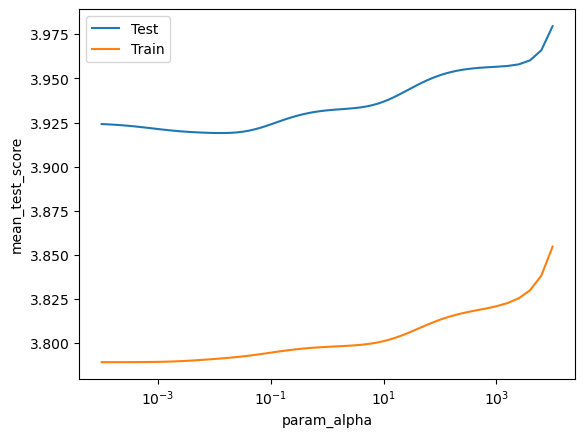

In [167]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [175]:
mejor = gs.best_estimator_
mostrar_rmse(mejor, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 3.8034
Test:  4.2822


In [176]:
formula_real = "~ poly(a, 2, raw=True) + poly(b, 2, raw=True) + a:b"
X_real = model_matrix(formula_real, data=X_train)
lr_real = LinearRegression()
lr_real.fit(X_real, y_train)
mostrar_rmse(lr_real, X_real, y_train, model_matrix(formula_real, X_test), y_test)


# RMSE
Train: 3.8520
Test:  4.2707


In [177]:
betas(lr_real, X_real).round(3)

Intercept    2.297
a            2.980
a^2         -0.793
b           -2.225
b^2          0.608
a:b          1.496
dtype: float64

Los coeficientes originales eran:
$$ z = 1 + 3x - 2y + 1.5 xy - 0.8 x^2 + 0.6 y^2 + \epsilon$$

Entonces, ¿es cierta la hipótesis? ¿Da lo mismo un modelo "genérico" con regularización que un modelo "ad-hoc"? ¿En qué tipo de tareas?

## Consigna

Cargue el dataset `wine` de scikit-learn, e intente predecir el contenido de alcohol (`alcohol`) de cada vino, usando las características a su disposición, usando una regresión Ridge sobre una matriz de diseño sesudamente construida.

NOTA: El dataset está preparado para utilizarlo en problemas de clasificación, así que tendrá que trocar el objetivo ("target") con la variable predictora "alcohol". Note que la etiqueta del vino peude ser de utilidad en el diseño del modelo.

In [179]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [172]:
dir(wine)  # estos son los atributos del objeto, exprorelos!

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']